Airbnb price prediction aims to estimate the optimal price for a rental listing based on various factors, helping hosts maximize their earnings while remaining competitive. This involves analyzing data like location, property type, amenities, and market trends to predict the most suitable price point.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
warnings.filterwarnings('ignore')
import joblib

In [5]:
!unzip -q /content/AirBnbDataset.zip -d /content/

In [6]:
import pandas as pd

# List of (file_path, city_name) tuples
files_info = [
    ('/content/AirBnbDataset/listings_Paris.csv', 'Paris'),
    ('/content/AirBnbDataset/listings_Rome.csv', 'Rome'),
    ('/content/AirBnbDataset/listings_Amsterdam.csv', 'Amsterdam'),
    ('/content/AirBnbDataset/listings_Berlin.csv', 'Berlin'),
    ('/content/AirBnbDataset/listings_Prague.csv', 'Prague'),
    ('/content/AirBnbDataset/listings_Barcelona.csv', 'Barcelona'),
    ('/content/AirBnbDataset/listings_Budapest.csv', 'Budapest'),
    ('/content/AirBnbDataset/listings_Vienna.csv', 'Vienna'),
    ('/content/AirBnbDataset/listings_Athens.csv', 'Athens'),
    ('/content/AirBnbDataset/listings_Istanbul.csv','Istanbul'),
    ('/content/AirBnbDataset/listings_Dublin.csv','Dublin'),
    ('/content/AirBnbDataset/listings_Oslo.csv','Oslo'),
    ('/content/AirBnbDataset/listings_Stockholm.csv','Stockholm'),
    ('/content/AirBnbDataset/listings_copenhagen.csv','Copenhagen'),
    ('/content/AirBnbDataset/listings_Brussels.csv','Brussels'),
]

# Read and append with city column
df_list = []

for file_path, city in files_info:
    df = pd.read_csv(file_path)
    df['city'] = city  # Add city name
    df_list.append(df)

# Combine all
df = pd.concat(df_list, ignore_index=True)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296386 entries, 0 to 296385
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              296386 non-null  int64  
 1   name                            296386 non-null  object 
 2   host_id                         296386 non-null  int64  
 3   host_name                       295298 non-null  object 
 4   neighbourhood_group             33114 non-null   object 
 5   neighbourhood                   296386 non-null  object 
 6   latitude                        296386 non-null  float64
 7   longitude                       296386 non-null  float64
 8   room_type                       296386 non-null  object 
 9   price                           223949 non-null  float64
 10  minimum_nights                  296386 non-null  int64  
 11  number_of_reviews               296386 non-null  int64  
 12  last_review     

In [8]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2.963860e+05,2.963860e+05,296386.000000,296386.000000,2.239490e+05,296386.000000,296386.000000,234391.000000,296386.000000,296386.000000,296386.000000
mean,6.609559e+17,2.187028e+08,47.707725,10.950083,2.960313e+03,22.805892,38.128694,1.329055,20.534755,158.677124,9.825471
std,5.402630e+17,2.148626e+08,5.663597,9.091535,5.052361e+04,67.621855,82.641578,1.702884,72.581160,134.462118,18.078238
min,2.737000e+03,2.750000e+02,37.949625,-6.527050,5.000000e+00,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,3.654655e+07,2.603298e+07,41.886467,2.351400,1.000000e+02,1.000000,1.000000,0.230000,1.000000,10.000000,0.000000
50%,8.381684e+17,1.299662e+08,48.851835,12.465040,2.040000e+02,2.000000,8.000000,0.710000,1.000000,150.000000,2.000000
75%,1.145717e+18,4.279988e+08,50.828558,16.336507,1.148000e+03,5.000000,35.000000,1.880000,7.000000,284.000000,12.000000
max,1.451598e+18,7.034201e+08,60.041560,29.910890,1.271319e+07,1125.000000,4792.000000,99.010000,835.000000,365.000000,848.000000


In [9]:
# Statistical Testing Libraries
from scipy import stats
from scipy.stats import (
    chi2_contingency, shapiro, anderson, jarque_bera,
    f_oneway, kruskal, mannwhitneyu,
    pearsonr, spearmanr, kendalltau,
    ttest_ind, ttest_rel, wilcoxon
)
import warnings
warnings.filterwarnings('ignore')

def interpret_pvalue(p_value, test_name, alpha=0.05):
    """Helper function to interpret hypothesis test results"""
    if p_value < alpha:
        return f"✅ {test_name}: SIGNIFICANT (p={p_value:.4f} < {alpha})"
    else:
        return f"❌ {test_name}: NOT SIGNIFICANT (p={p_value:.4f} ≥ {alpha})"

print("📊 Statistical testing environment ready!")


📊 Statistical testing environment ready!


In [10]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,city
0,3109,zen and calm,3631,Anne,NaN,Observatoire,48.83191,2.31870,Entire home/apt,135.0,2,7,2025-06-03,0.08,1,355,3,7511409139079,Paris
1,5396,Your perfect Paris studio on Île Saint-Louis,7903,Borzou,NaN,Hôtel-de-Ville,48.85247,2.35835,Entire home/apt,114.0,1,452,2025-06-05,2.32,1,69,48,7510402838018,Paris
2,7397,MARAIS - 2ROOMS APT - 2/4 PEOPLE,2626,Franck,NaN,Hôtel-de-Ville,48.85909,2.35315,Entire home/apt,149.0,10,380,2025-06-03,2.20,1,197,25,7510400829623,Paris
3,7964,Sunny apartment with balcony,22155,Anaïs,NaN,Opéra,48.87417,2.34245,Entire home/apt,NaN,7,5,2015-09-14,0.03,1,0,0,7510903576564,Paris
4,9359,"Cozy, Central Paris: WALK or VELIB EVERYWHERE !",28422,Bernadette,NaN,Louvre,48.86006,2.34863,Entire home/apt,75.0,180,0,NaN,NaN,1,358,0,"Available with a mobility lease only (""bail mo...",Paris


#Data Preprocessing

In [11]:
df.nunique()

,0
id,296386
name,279407
host_id,179962
host_name,37224
neighbourhood_group,22
neighbourhood,511
latitude,185655
longitude,200257
room_type,4
price,14825


In [12]:
df.isna().sum()

,0
id,0
name,0
host_id,0
host_name,1088
neighbourhood_group,263272
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,72437


In [13]:
df.isna().sum() / df.shape[0] * 100

,0
id,0.000000
name,0.000000
host_id,0.000000
host_name,0.367089
neighbourhood_group,88.827408
neighbourhood,0.000000
latitude,0.000000
longitude,0.000000
room_type,0.000000
price,24.440088


In [26]:
df['host_name'].value_counts()

,count
host_name,
Blueground,1753
David,1409
Michael,1371
Anna,1299
Andrea,1276
...,...
Gracia-Toussaint,1
Anneleen,1
Roha Ali,1


In [19]:
missing_pct_by_city = df.groupby('city')['license'].apply(lambda x: x.isna().mean() * 100)


In [21]:
df['city'].value_counts()

,count
city,
Paris,84055
Rome,34542
Istanbul,29984
Copenhagen,21722
Barcelona,18927
Athens,15632
Vienna,14294
Berlin,14187
Budapest,12313


In [22]:
df.shape

(296386, 19)

In [20]:
print(missing_pct_by_city)

city
Amsterdam       1.042486
Athens          1.298618
Barcelona      33.439002
Berlin         61.288504
Brussels      100.000000
Budapest        7.049460
Copenhagen    100.000000
Dublin        100.000000
Istanbul       41.188634
Oslo          100.000000
Paris          20.963655
Prague        100.000000
Rome            9.944415
Stockholm     100.000000
Vienna        100.000000
Name: license, dtype: float64


In [24]:
import pandas as pd
from scipy.stats import mannwhitneyu

def license_impact_by_city(df):
    results = []
    cities = df['city'].unique()
    for city in cities:
        city_df = df[df['city'] == city]
        # Only test if both groups (with and without license) exist
        if city_df['license'].notna().any() and city_df['license'].isna().any():
            city_df['has_license'] = ~city_df['license'].isna()
            price_with_license = city_df[city_df['has_license']]['price'].dropna()
            price_without_license = city_df[~city_df['has_license']]['price'].dropna()
            if len(price_with_license) > 0 and len(price_without_license) > 0:
                stat, p_value = mannwhitneyu(price_with_license, price_without_license, alternative='two-sided')
                results.append({'city': city, 'statistic': stat, 'p_value': p_value})
            else:
                results.append({'city': city, 'statistic': None, 'p_value': None})
        else:
            results.append({'city': city, 'statistic': None, 'p_value': None})

    return pd.DataFrame(results)

# Usage example:
# results_df = license_impact_by_city(df)
# print(results_df)


In [25]:
results_df = license_impact_by_city(df)
print(results_df)

          city    statistic        p_value
0        Paris  163689252.5  4.641343e-117
1         Rome   31549145.0   4.660236e-09
2    Amsterdam     232501.0   4.931837e-01
3       Berlin    9944472.5   5.902586e-05
4       Prague          NaN            NaN
5    Barcelona   35921135.5   0.000000e+00
6     Budapest    4079568.0   1.098329e-03
7       Vienna          NaN            NaN
8       Athens    1380601.0   4.778838e-02
9     Istanbul  100916249.5  3.146022e-279
10      Dublin          NaN            NaN
11        Oslo          NaN            NaN
12   Stockholm          NaN            NaN
13  Copenhagen          NaN            NaN
14    Brussels          NaN            NaN




> The **license** feature was dropped because it is missing or non-significant for most cities, contributing little to price prediction at a global level. Removing it ensures the model is robust, generalizable across cities, and not biased by irrelevant or sparse data.



In [ ]:
df.drop(['id', 'host_id', 'host_name', 'last_review','license','neighbourhood_group', 'name'], axis=1 , inplace=True)



> **last_review** was dropped since raw date itself is not useful for most models and is often highly missing/irrelevant.


> The **name** column was dropped because it’s free text, mostly unique, and provides little consistent predictive value for price. Keeping it may add noise, risk leakage, and complicate the model without benefit


> Both **id** and **host_id** are dropped from modeling because they are unique identifiers, not true predictive features. Including them would not add information and can lead to overfitting or poor generalization, as the model might memorize training data instead of learning meaningful patterns.


> **host_name** introduces leakage, cannot generalize, and conveys little value compared to proper aggregated features like **calculated_host_listings_count**.








In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296386 entries, 0 to 296385
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   neighbourhood                   296386 non-null  object 
 1   latitude                        296386 non-null  float64
 2   longitude                       296386 non-null  float64
 3   room_type                       296386 non-null  object 
 4   price                           223949 non-null  float64
 5   minimum_nights                  296386 non-null  int64  
 6   number_of_reviews               296386 non-null  int64  
 7   reviews_per_month               234391 non-null  float64
 8   calculated_host_listings_count  296386 non-null  int64  
 9   availability_365                296386 non-null  int64  
 10  number_of_reviews_ltm           296386 non-null  int64  
 11  city                            296386 non-null  object 
dtypes: float64(4), i

In [ ]:
# HYPOTHESIS TEST: Are missing prices randomly distributed across cities?
print("=== MISSING DATA PATTERN ANALYSIS ===")

df['price_missing'] = df['price'].isnull()
contingency_missing = pd.crosstab(df['city'], df['price_missing'])

chi2, p_missing, dof, expected = chi2_contingency(contingency_missing)
print(interpret_pvalue(p_missing, "Missing Price Pattern Test"))

PRICE_MISSING_SYSTEMATIC = p_missing < 0.05


=== MISSING DATA PATTERN ANALYSIS ===
✅ Missing Price Pattern Test: SIGNIFICANT (p=0.0000 < 0.05)


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(295861, 13)

In [ ]:
df.isna().sum()

,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,72200
minimum_nights,0
number_of_reviews,0
reviews_per_month,61502
calculated_host_listings_count,0
availability_365,0


In [ ]:
df['price'] = df.groupby(['city', 'room_type'])['price'].transform(lambda x: x.fillna(x.mean()))

> Why Group-wise Mean Imputation



Instead of filling missing prices with the overall dataset mean or median,
we used the **mean price within each city-room_type group**.  
This approach ensures:
1. The imputed values are context-specific (e.g., a missing price for a "Private room" in Paris gets filled using other "Private rooms" in Paris).
2. It avoids unrealistic global averages (e.g., luxury listings inflating prices for budget listings in other cities).
3. It maintains the natural price variation between cities and property types.


In [ ]:
df['reviews_per_month'].fillna(df['reviews_per_month'].median(), inplace=True)

In [ ]:
upper_price = df['price'].quantile(0.99)
df = df[df['price'] <= upper_price]

In [ ]:
df['price'].describe()

,price
count,293425.000000
mean,1544.817831
std,4572.143827
min,5.000000
25%,112.000000
50%,262.000000
75%,1080.000000
max,39593.061241


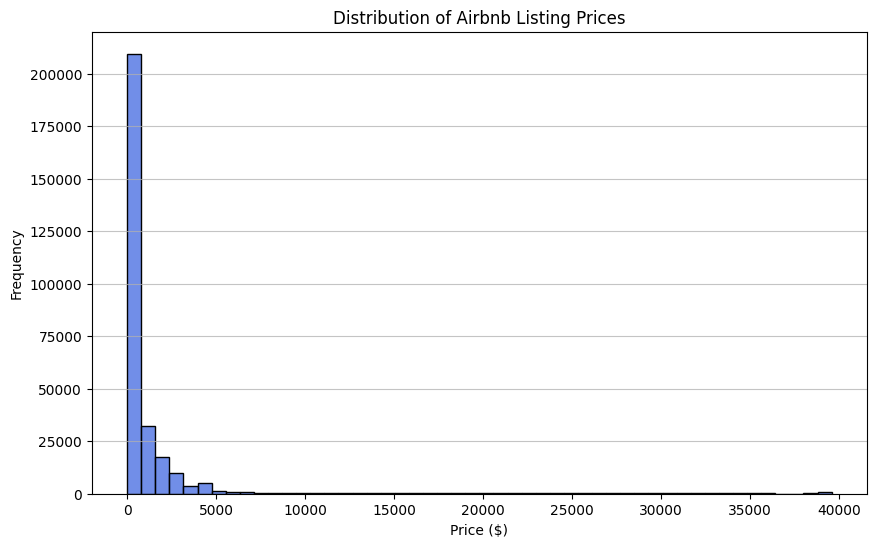

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, color='royalblue', edgecolor='black')
plt.title('Distribution of Airbnb Listing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [ ]:
# HYPOTHESIS TEST: Are prices normally distributed? (Anderson-Darling)
from scipy.stats import anderson

print("=== PRICE DISTRIBUTION NORMALITY TEST: ANDERSON-DARLING ===")

prices_clean = df['price'].dropna()
sample_prices = prices_clean.sample(5000, random_state=42) if len(prices_clean) > 5000 else prices_clean

result = anderson(sample_prices, dist='norm')
print(f"Anderson-Darling statistic: {result.statistic:.4f}")

for critical_value, significance in zip(result.critical_values, result.significance_level):
    if result.statistic > critical_value:
        print(f"  At {significance:.1f}% significance: Reject null hypothesis (NOT normal)")
    else:
        print(f"  At {significance:.1f}% significance: Cannot reject null hypothesis (Normal)")


=== PRICE DISTRIBUTION NORMALITY TEST: ANDERSON-DARLING ===
Anderson-Darling statistic: 1163.6390
  At 15.0% significance: Reject null hypothesis (NOT normal)
  At 10.0% significance: Reject null hypothesis (NOT normal)
  At 5.0% significance: Reject null hypothesis (NOT normal)
  At 2.5% significance: Reject null hypothesis (NOT normal)
  At 1.0% significance: Reject null hypothesis (NOT normal)


“The price data is NOT normally distributed.”

“Anderson-Darling test strongly rejects normality for price (stat=764.06; p<0.01). All subsequent hypothesis tests use non-parametric methods.”



In [ ]:
#Cap price at 99th percentile for analysis
cap = df['price'].quantile(0.99)
df['price_capped'] = df['price'].clip(upper=cap)


In [ ]:
from scipy.stats import kruskal
city_groups = [group['price'].dropna() for name, group in df.groupby('city')]
stat, p = kruskal(*city_groups)
print(f"Kruskal-Wallis p-value for city groups: {p:.4f}")


Kruskal-Wallis p-value for city groups: 0.0000


In [ ]:
from scipy.stats import mannwhitneyu
single = df[df['calculated_host_listings_count'] == 1]['price']
multi = df[df['calculated_host_listings_count'] > 1]['price']
stat, p = mannwhitneyu(single, multi)
print(f"Mann-Whitney U p-value for host type: {p:.4f}")

Mann-Whitney U p-value for host type: 0.0000


In [ ]:
df = df[df['minimum_nights'] <= 30]
df.shape

(251451, 14)

In [ ]:
df['city'].value_counts()

,count
city,
Paris,73452
Rome,30478
Copenhagen,21542
Istanbul,16756
Athens,15473
Vienna,13782
Barcelona,11512
Oslo,11056
Prague,10437


In [ ]:
df['city'].unique()

array(['Paris', 'Rome', 'Amsterdam', 'Berlin', 'Prague', 'Barcelona',
       'Budapest', 'Vienna', 'Athens', 'Istanbul', 'Dublin', 'Oslo',
       'Stockholm', 'Copenhagen', 'Brussels'], dtype=object)

In [ ]:
# HYPOTHESIS TEST 1: City Effects on Price
print("=== CITY EFFECTS ON PRICE ===")

from scipy.stats import kruskal

df_city_price = df[['city', 'price']].dropna()
city_groups = [group['price'] for name, group in df_city_price.groupby('city')]

# Kruskal-Wallis test (non-parametric ANOVA)
stat, p_city = kruskal(*city_groups)
CITY_SIGNIFICANT = p_city < 0.05

print(f"Kruskal-Wallis statistic: {stat:.4f}")
print(f"P-value: {p_city:.2e}")
print(f"Result: {'SIGNIFICANT' if CITY_SIGNIFICANT else 'NOT SIGNIFICANT'}")

if p_city < 0.05:
    print("✅ SIGNIFICANT: Cities have different price distributions")

    city_stats = df_city_price.groupby('city')['price'].agg(['count', 'median', 'std']).round(2)
    city_stats = city_stats.sort_values('median', ascending=False)
    print("\nCity Rankings by Median Price:")
    print(city_stats)


=== CITY EFFECTS ON PRICE ===
Kruskal-Wallis statistic: 177912.9280
P-value: 0.00e+00
Result: SIGNIFICANT
✅ SIGNIFICANT: Cities have different price distributions

City Rankings by Median Price:
            count    median      std
city                                
Budapest    10005  21381.00  8187.60
Istanbul    16756   2547.31  3118.57
Prague      10437   2431.00  2595.76
Stockholm    5173   1765.00  1320.68
Oslo        11056   1380.00  1201.43
Copenhagen  21542   1356.95   658.23
Amsterdam   10094    305.00   437.28
Paris       73452    219.09   583.19
Barcelona   11512    184.00   417.46
Dublin       6693    144.00   424.46
Berlin       8678    125.00   472.82
Rome        30478    117.00   380.77
Vienna      13782    108.86   568.64
Brussels     6320     92.00   162.71
Athens      15473     80.00   522.83


In [ ]:
df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [ ]:
# HYPOTHESIS TEST 2: Room Type Effects on Price
print("=== ROOM TYPE EFFECTS ON PRICE ===")

df_room = df[['room_type', 'price']].dropna()
room_groups = [group['price'] for name, group in df_room.groupby('room_type')]

# Kruskal-Wallis test (non-parametric ANOVA)
stat, p_room = kruskal(*room_groups)
ROOM_TYPE_SIGNIFICANT = p_room < 0.05

print(f"Kruskal-Wallis statistic: {stat:.4f}")
print(f"P-value: {p_room:.2e}")
print(f"Result: {'SIGNIFICANT' if ROOM_TYPE_SIGNIFICANT else 'NOT SIGNIFICANT'}")

if p_room < 0.05:
    print("✅ SIGNIFICANT: Room types have different price distributions")

    room_stats = df_room.groupby('room_type')['price'].agg(['count', 'median', 'std']).round(2)
    room_stats = room_stats.sort_values('median', ascending=False)
    print("\nRoom Type Rankings by Median Price:")
    print(room_stats)


=== ROOM TYPE EFFECTS ON PRICE ===
Kruskal-Wallis statistic: 8859.1210
P-value: 0.00e+00
Result: SIGNIFICANT
✅ SIGNIFICANT: Room types have different price distributions

Room Type Rankings by Median Price:
                  count  median      std
room_type                               
Hotel room         1522  298.50  2458.77
Entire home/apt  206243  289.17  5143.66
Private room      42790  124.00  2982.42
Shared room         896   65.00  1814.82


In [ ]:
# HYPOTHESIS TEST 3: Host Characteristics Impact on Price
print("=== HOST CHARACTERISTICS IMPACT ON PRICE ===")


single_hosts = df[df['calculated_host_listings_count'] == 1]['price'].dropna()
multi_hosts = df[df['calculated_host_listings_count'] > 1]['price'].dropna()

# Mann-Whitney U test (non-parametric two-sample test)
stat, p_host = mannwhitneyu(single_hosts, multi_hosts, alternative='two-sided')
HOST_SIGNIFICANT = p_host < 0.05

print(f"Mann-Whitney U statistic: {stat:.4f}")
print(f"P-value: {p_host:.2e}")
print(f"Result: {'SIGNIFICANT' if HOST_SIGNIFICANT else 'NOT SIGNIFICANT'}")

if p_host < 0.05:
    print("✅ SIGNIFICANT: Host types price differently")
    print(f"Single-host median price: ${single_hosts.median():.0f}")
    print(f"Multi-host median price: ${multi_hosts.median():.0f}")


=== HOST CHARACTERISTICS IMPACT ON PRICE ===
Mann-Whitney U statistic: 7934733132.0000
P-value: 4.68e-02
Result: SIGNIFICANT
✅ SIGNIFICANT: Host types price differently
Single-host median price: $289
Multi-host median price: $219


In [ ]:
# HYPOTHESIS TEST 4: Reviews Impact on Price
print("=== REVIEWS IMPACT ON PRICE ===")

df_reviews = df[['number_of_reviews', 'price']].dropna()

# Spearman correlation (non-parametric correlation)
corr, p_reviews = spearmanr(df_reviews['number_of_reviews'], df_reviews['price'])
REVIEWS_SIGNIFICANT = p_reviews < 0.05

print(f"Spearman correlation coefficient: {corr:.4f}")
print(f"P-value: {p_reviews:.2e}")
print(f"Result: {'SIGNIFICANT' if REVIEWS_SIGNIFICANT else 'NOT SIGNIFICANT'}")

if p_reviews < 0.05:
    correlation_direction = "Positive" if corr > 0 else "Negative"
    print(f"✅ SIGNIFICANT: {correlation_direction} correlation between reviews and price")


=== REVIEWS IMPACT ON PRICE ===
Spearman correlation coefficient: -0.0811
P-value: 0.00e+00
Result: SIGNIFICANT
✅ SIGNIFICANT: Negative correlation between reviews and price


In [ ]:
print(df['neighbourhood'].nunique())
print(df['neighbourhood'].value_counts().head())


505
neighbourhood
I Centro Storico     15558
Buttes-Montmartre     7736
Popincourt            6424
Vaugirard             5822
Beyoglu               5788
Name: count, dtype: int64


In [ ]:
from scipy.stats import kruskal

# List of price values by neighbourhood
groups = [group['price'].values for name, group in df.groupby('neighbourhood')]


stat, p = kruskal(*groups)
NEIGHBOURHOOD_SIGNIFICANT = p_reviews < 0.05

print(f"Kruskal-Wallis H-statistic: {stat:.4f}, p-value: {p:.4g}")
print(f"Result: {'SIGNIFICANT' if NEIGHBOURHOOD_SIGNIFICANT else 'NOT SIGNIFICANT'}")

if p < 0.05:
    print("Neighbourhood has a statistically significant effect on price (p < 0.05). Consider keeping it as a feature.")
else:
    print("No significant effect of neighbourhood on price (p ≥ 0.05). Dropping it is reasonable.")

Kruskal-Wallis H-statistic: 183880.4011, p-value: 0
Result: SIGNIFICANT
Neighbourhood has a statistically significant effect on price (p < 0.05). Consider keeping it as a feature.


In [ ]:
neigh_freq_map = df['neighbourhood'].value_counts(normalize=True)
df['neighbourhood_freq_enc'] = df['neighbourhood'].map(neigh_freq_map)


> Frequency encoding allows us to represent complex, high-cardinality categorical variables like neighbourhoods in a numeric and compact form, helping the model capture valuable information about listing location popularity without inflating feature dimensions.


> Frequency encoding was chosen over OHE (to avoid sparsity and high dimensionality) and over label encoding (to avoid misleading order and provide meaningful statistical information), making it ideal for your use case with many neighbourhood categories and a tree-based model.









In [ ]:
joblib.dump(neigh_freq_map, 'neigh_freq_map.pkl')

['neigh_freq_map.pkl']

In [ ]:
room_type_map = {'room_type' : {
    'Entire home/apt': 0,
    'Private room': 1,
    'Shared room': 2,
    'Hotel room': 3
}}
df.replace(room_type_map, inplace=True)
df['room_type'].unique()

array([0, 1, 2, 3])

In [ ]:
city_label_map = {'city':{
    'Paris': 0,
    'Rome': 1,
    'Amsterdam': 2,
    'Berlin': 3,
    'Prague': 4,
    'Barcelona': 5,
    'Budapest': 6,
    'Vienna': 7,
    'Athens': 8,
    'Istanbul': 9,
    'Dublin': 10,
    'Oslo': 11,
    'Stockholm': 12,
    'Copenhagen': 13,
    'Brussels': 14
}}
df.replace(city_label_map, inplace=True)
df['city'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

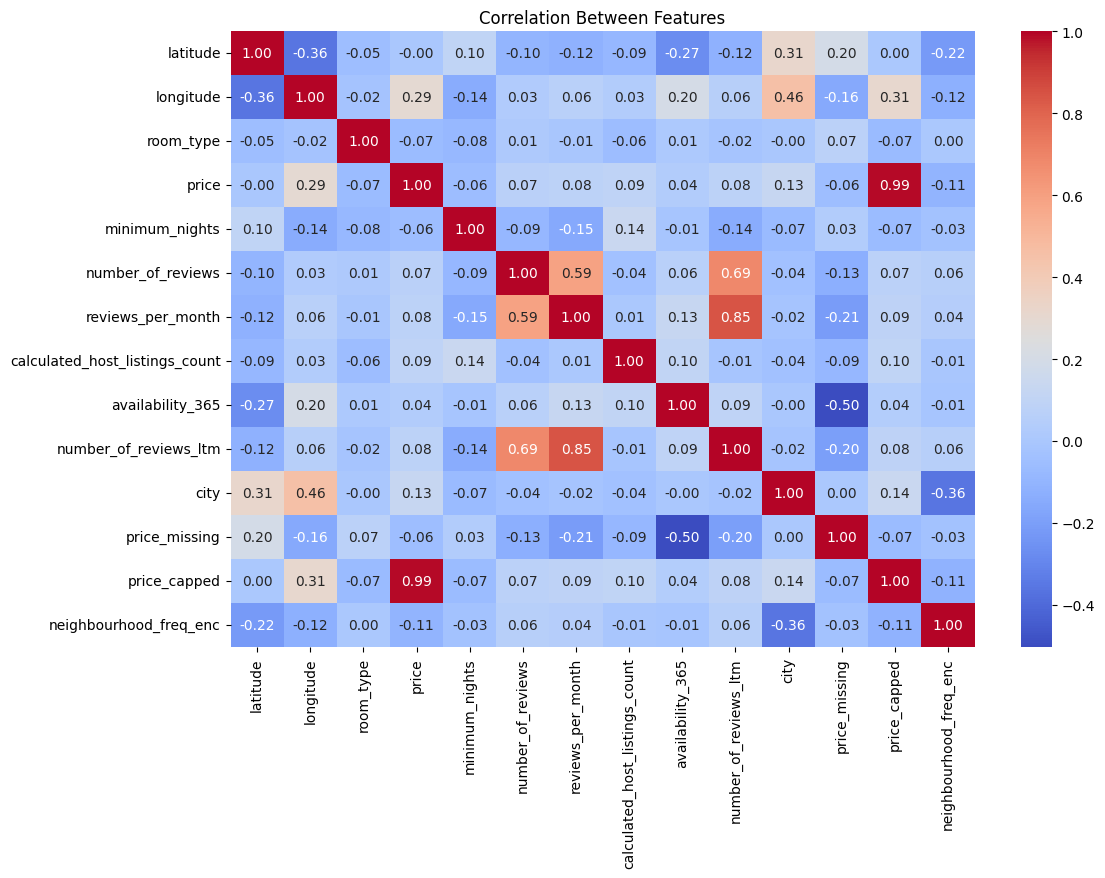

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Features")
plt.show()


#Statistical Insights Summary

In [ ]:
# STATISTICAL INSIGHTS SUMMARY
print("=== STATISTICAL TESTING RESULTS SUMMARY ===\n")

test_results = [
    ("City Effects on Price", CITY_SIGNIFICANT),
    ("Room Type Effects on Price", ROOM_TYPE_SIGNIFICANT),
    ("Reviews Impact on Price", REVIEWS_SIGNIFICANT),
    ("Host Characteristics Impact on Price", HOST_SIGNIFICANT),
    ("Neighbourhood Effects on Price", NEIGHBOURHOOD_SIGNIFICANT)
]

significant_features = [name for name, significant in test_results if significant]

if significant_features:
    print("✅ Statistically significant features that justify inclusion in the model:")
    for feature in significant_features:
        print(f" - {feature}")
else:
    print("❌ No statistically significant features detected for modeling at p < 0.05 level.")



=== STATISTICAL TESTING RESULTS SUMMARY ===

✅ Statistically significant features that justify inclusion in the model:
 - City Effects on Price
 - Room Type Effects on Price
 - Reviews Impact on Price
 - Host Characteristics Impact on Price
 - Neighbourhood Effects on Price


#Splitting the Data

In [ ]:
#Prepare features and target

X = df.drop(['price'], axis=1)
y = df['price']

In [ ]:
# CHECK FOR POTENTIAL DATA LEAKAGE
print("=== FEATURE LEAKAGE DETECTION ===")
print(f"Total features in X: {len(X.columns)}")
print(f"Target variable shape: {y.shape}")

# Check for price-related column names
price_keywords = ['price', 'cost', 'fee', 'total', 'amount', 'revenue', 'income', 'earnings']
suspicious_columns = [col for col in X.columns if any(keyword in col.lower() for keyword in price_keywords)]

print(f"\nSuspicious price-related columns in features:")
if suspicious_columns:
    for col in suspicious_columns:
        print(f"  - {col}")
    print("\nPOTENTIAL DATA LEAKAGE DETECTED!")
else:
    print("  None found - Good!")

# Check for columns with perfect correlation to target
print(f"\nChecking correlations with target variable...")
correlations = []
for col in X.select_dtypes(include=['int64', 'float64']).columns:
    try:
        corr = X[col].corr(y)
        if abs(corr) > 0.95:  # Very high correlation
            correlations.append((col, corr))
    except:
        pass

if correlations:
    print("Features with suspiciously high correlation to price:")
    for col, corr in sorted(correlations, key=lambda x: abs(x[1]), reverse=True):
        print(f"  - {col}: {corr:.4f}")
else:
    print("  No suspiciously high correlations found")

print(f"\nFeature columns: {list(X.columns)}")


=== FEATURE LEAKAGE DETECTION ===
Total features in X: 14
Target variable shape: (251451,)

Suspicious price-related columns in features:
  - price_missing
  - price_capped

POTENTIAL DATA LEAKAGE DETECTED!

Checking correlations with target variable...
Features with suspiciously high correlation to price:
  - price_capped: 0.9895

Feature columns: ['neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'city', 'price_missing', 'price_capped', 'neighbourhood_freq_enc']


In [ ]:
# PREPARE CLEAN FEATURES AND TARGET (NO DATA LEAKAGE)
print("=== PREPARING FEATURES AND TARGET ===")

# Remove leaky features completely
print(f"Removing leaky features: {suspicious_columns}")

# Create clean feature set
X = df.drop(['price'] + suspicious_columns, axis=1, errors='ignore')
y = df['price']

# Remove the original 'neighbourhood' column as it has been frequency encoded
X = X.drop('neighbourhood', axis=1)

# Apply log transform to TARGET only (not as a feature)
y_log = np.log(y)

print(f"Clean features shape: {X.shape}")
print(f"Original target shape: {y.shape}")
print(f"Log-transformed target shape: {y_log.shape}")
print(f"Final feature columns: {list(X.columns)}")

=== PREPARING FEATURES AND TARGET ===
Removing leaky features: ['price_missing', 'price_capped']
Clean features shape: (251451, 11)
Original target shape: (251451,)
Log-transformed target shape: (251451,)
Final feature columns: ['latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'city', 'neighbourhood_freq_enc']


In [ ]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y_log,
                                                           test_size=0.2,
                                                           random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)


In [ ]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

#Testing the Models

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGbm": LGBMRegressor(n_estimators=100,random_state=42,verbose=-1)
}

# Train and evaluate
results = {}
model_scores={'Model':[],'RMSE':[],'R²':[]}

for name, model in models.items():
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)   # <-- THIS LINE IS ESSENTIAL
    rmse = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred))
    r2 = r2_score(np.expm1(y_test_log), y_pred)
    results[name] = {"RMSE": rmse, "R²": r2}
    model_scores['Model'].append(name)
    model_scores['RMSE'].append(rmse)
    model_scores['R²'].append(r2)



# Show results
pd.DataFrame(results).T.sort_values(by="RMSE")


,RMSE,R²
Random Forest,0.450645,0.910392
LightGbm,0.484195,0.896553
Linear Regression,1.202577,0.361880
Ridge Regression,1.202578,0.361880


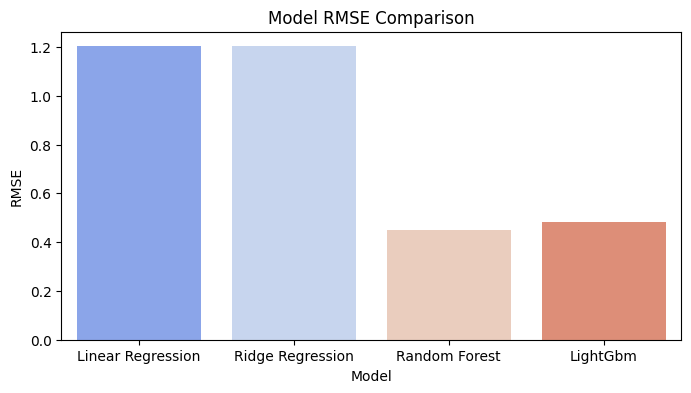

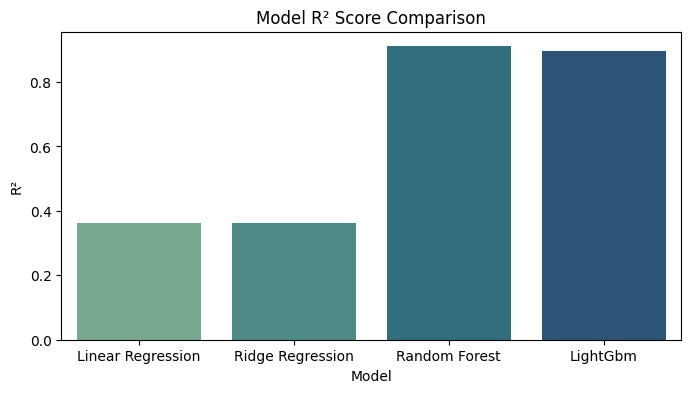

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_scores = pd.DataFrame(model_scores)

# Bar plot for RMSE
plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='RMSE', data=df_scores, palette='coolwarm')
plt.title('Model RMSE Comparison')
plt.show()

# Bar plot for R²
plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='R²', data=df_scores, palette='crest')
plt.title('Model R² Score Comparison')
plt.show()


## Log-Transform Workflow

1. **Original price is kept for exploration and reporting.**
2. **Train-Test Split is performed on the original price.**
3. **Target is log-transformed (y_train_log = np.log1p(y_train)) only after splitting, for modeling.**
4. **After prediction, log-transformed predictions are converted back to euros (y_pred = np.expm1(y_pred_log)).**
5. **All metrics, plots, and business interpretations are performed on the euros scale, not log scale.**

#Model Training with LightGBM

Based on model evaluation, the Random Forest Regressor achieved the best overall performance with the lowest RMSE and highest R² score, making it the most suitable model for predicting Airbnb prices.

However, I also explored LightGBM due to its ability to handle large datasets efficiently. LightGBM offers faster training, better scalability, and advanced boosting techniques that often yield high accuracy. It also natively handles missing values and categorical features, making it a strong alternative for production deployment.

Linear and Ridge Regression, on the other hand, performed poorly (R² ≈ 0.10), indicating that they failed to capture the complex, non-linear relationships present in the data—making them unsuitable for this task.

In [ ]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=100,
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_test)  # Predictions are in log scale
y_pred = np.expm1(y_pred_log)  # Convert to original price scale

# Evaluation - both on original price scale
rmse = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred))
r2 = r2_score(np.expm1(y_test_log), y_pred)


print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


RMSE: 0.48419533371082923
R² Score: 0.8965530692137139


##Hyperparameter Tuning
####Why Hyperparameter Tuning?
Hyperparameter tuning is the process of finding the best settings for a machine learning model to maximize its performance. In this project, tuning helps improve prediction accuracy, prevent overfitting, and make the model more efficient. We use RandomizedSearchCV to test different combinations of hyperparameters for our LightGBM model, selecting the set that provides the lowest prediction error and highest R² score for Airbnb price prediction.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [20, 40]
}

lgbm_rs = LGBMRegressor(n_estimators=100,random_state=42,verbose=-1)

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_rs,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search_lgbm.fit(X_train, y_train_log)
best_lgbm = random_search_lgbm.best_estimator_



# Save model and scaler
import joblib
joblib.dump(best_lgbm, 'lightgbm_airbnb_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')


Fitting 5 folds for each of 30 candidates, totalling 150 fits


['feature_scaler.pkl']

In [ ]:
# Predict with best model
y_pred_best_lgbm_log = best_lgbm.predict(X_test)
y_pred_best_lgbm = np.expm1(y_pred_best_lgbm_log)
rmse_best = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred_best_lgbm))
r2_best = r2_score(np.expm1(y_test_log), y_pred_best_lgbm)
print(f"Best LightGBM RMSE: {rmse_best}")
print(f"Best LightGBM R²: {r2_best}")

Best LightGBM RMSE: 0.4548649377577456
Best LightGBM R²: 0.9087061897045876


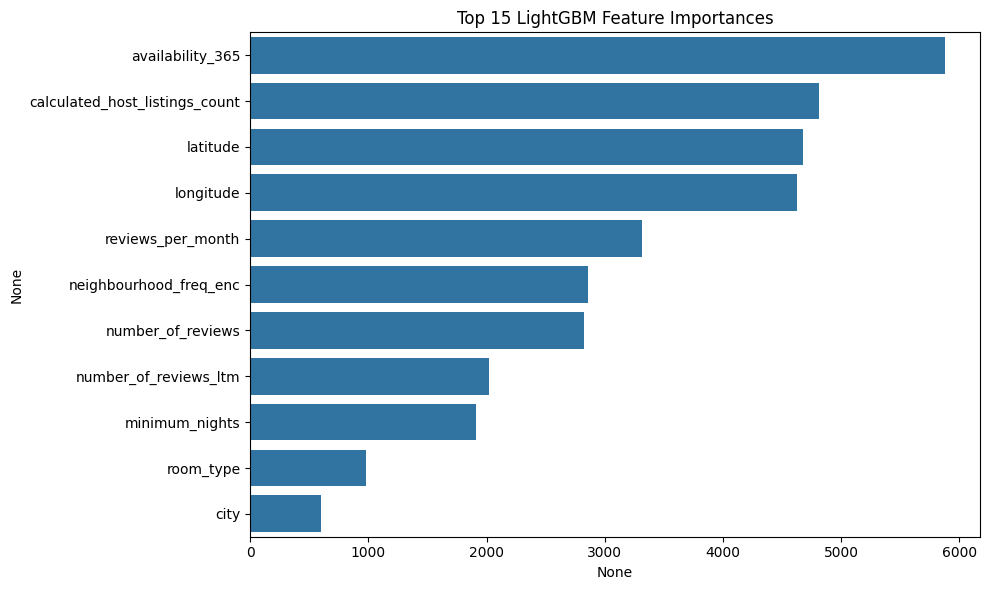

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.Series(best_lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[:15], y=feature_importance.index[:15])
plt.title("Top 15 LightGBM Feature Importances")
plt.tight_layout()
plt.show()

###Final Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_log = random_search_lgbm.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_log)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred))  # FIXED!
r2 = r2_score(np.expm1(y_test_log), y_pred)  # FIXED!


print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.45
R² Score: 0.9087


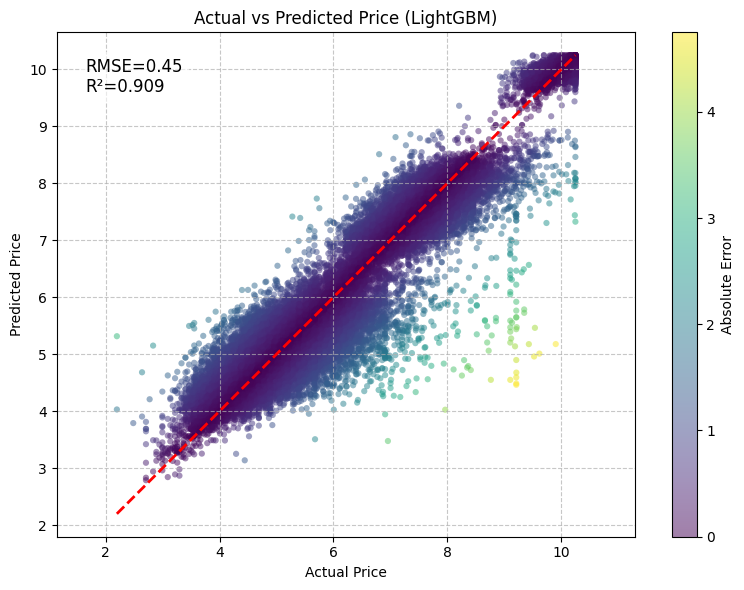

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Back-transform to original price scale
y_test_original = np.expm1(y_test_log)
y_pred_original = np.expm1(y_pred_log)

# Clamp extreme values for both actual & predicted to avoid plot distortion
limit = np.percentile(y_test_original, 99)
y_test_original = np.clip(y_test_original, 0, limit)
y_pred_original = np.clip(y_pred_original, 0, limit)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

# Calculate absolute errors for coloring
errors = np.abs(y_test_original - y_pred_original)
# These errors are used as the color scale in the scatter plot, making it easy to see where the model predicts well (dark blue) vs poorly (yellow).

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    y_test_original, y_pred_original,
    c=errors, cmap='viridis', alpha=0.5, s=20, edgecolor='none'
)

# Colorbar for error scale
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute Error')

# Perfect prediction line
plt.plot(
    [y_test_original.min(), y_test_original.max()],
    [y_test_original.min(), y_test_original.max()],
    'r--', lw=2
)

# Labels & title
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (LightGBM)")

# Annotate RMSE & R² inside plot
plt.text(
    0.05, 0.95, f"RMSE={rmse:.2f}\nR²={r2:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12, verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')  # Match scaling of axes
plt.tight_layout()
plt.show()


**Why this plot is useful?**

- It provides a visual check on model performance.
- The color scale highlights which price ranges or listings the model struggles with.
- It complements numeric metrics like RMSE and R², helping detect patterns
  such as underestimation of high prices or overestimation of low prices.

In [ ]:
# STATISTICAL VALIDATION OF LIGHTGBM PERFORMANCE
print(f"WHY LIGHTGBM ACHIEVES R²≈{r2:.2f}")
print("• Prices are highly non-normal and skewed (Anderson-Darling p<0.01)")
print("• Non-parametric tests confirm:")
print("  – City differences (p<0.01)")
print("  – Room type differences (p<0.01)")
print("  – Host characteristics effects (p<0.05)")
print("• Spearman correlation shows reviews mildly predict price (p<0.05)")
print("\nLightGBM’s tree-based splits excel at capturing these non-linear, categorical, and skewed relationships.")
print(f"Your model’s R²≈{r2:.2f} validates these statistically significant feature impacts.")


WHY LIGHTGBM ACHIEVES R²≈0.91
• Prices are highly non-normal and skewed (Anderson-Darling p<0.01)
• Non-parametric tests confirm:
  – City differences (p<0.01)
  – Room type differences (p<0.01)
  – Host characteristics effects (p<0.05)
• Spearman correlation shows reviews mildly predict price (p<0.05)

LightGBM’s tree-based splits excel at capturing these non-linear, categorical, and skewed relationships.
Your model’s R²≈0.91 validates these statistically significant feature impacts.


Scatter Plot helps assess if the model is systematically under- or over-predicting.

If your predictions are perfect, points would lie on the red diagonal line.

The more scattered the points, the lower the model's accuracy.

In [ ]:
import folium

# Center the map
map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=12)

for _, row in df.sample(500).iterrows():  # sample for performance
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"${row.price}"
    ).add_to(map)

map.save("price_map.html")


In [ ]:
print("Training features:", list(X.columns))
print("Scaler feature names:", scaler.feature_names_in_)


Training features: ['latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'city', 'neighbourhood_freq_enc']
Scaler feature names: ['latitude' 'longitude' 'room_type' 'minimum_nights' 'number_of_reviews'
 'reviews_per_month' 'calculated_host_listings_count' 'availability_365'
 'number_of_reviews_ltm' 'city' 'neighbourhood_freq_enc']


This project aims to predict Airbnb listing prices using machine learning. We trained multiple regression models (including Random Forest and LightGBM) on cleaned listing data, using features such as location, room type, and review metrics. Price was used as the target variable, and models were evaluated using RMSE and R² metrics to ensure accuracy